In [44]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [45]:
data_df = pd.read_csv('data/DoAScoring-TitlesMultilabelDataset.csv',delimiter=";",encoding_errors="ignore")


def labels(title):
    return [title["role_flag"],title["focus_area_flag"],title["region_flag"],title["agency_flag"]]
Y = data_df.apply(labels,axis=1)
X=data_df["title"].astype(str).str.strip()
#split data into training and validation data
data_train, data_test, labels_train, labels_test = train_test_split(X, Y, test_size=0.1, random_state=42)
data_train, data_val, labels_train, labels_val = train_test_split(data_train, labels_train, test_size=0.2, random_state=42)


print("train data",data_train.shape)
print("val data",data_val.shape)
print("test data",data_test.shape)
print("train labels",labels_train.shape)
print("val labels",labels_val.shape)
print("test labels",labels_test.shape)

train data (540,)
val data (135,)
test data (75,)
train labels (540,)
val labels (135,)
test labels (75,)


In [46]:
#GLOVE has several embedding dimesion options
#https://nlp.stanford.edu/projects/glove/
EMBEDDING_DIM = 300
MAX_VOCAB_SIZE = 16384
MAX_SEQUENCE_LEN = 32

In [47]:
#load embedding 
print(f'Loading GloVe {EMBEDDING_DIM}-d embedding... ', end='')
word2vec = {}
with open(f'tmp/glove.6B.{EMBEDDING_DIM}d.txt', encoding="utf8") as f:
    for line in f:
        word, vector = line.split(maxsplit=1)
        word2vec[word] = np.fromstring(vector,'f', sep=' ')
print(f'done ({len(word2vec)} word vectors loaded)')

Loading GloVe 300-d embedding... done (18593 word vectors loaded)


In [48]:
#define tokenizing layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE + 2,
    output_sequence_length=MAX_SEQUENCE_LEN,
)
vectorize_layer.adapt(data_train.to_numpy())

print(f'Vocabulary length: {len(vectorize_layer.get_vocabulary())}')

Vocabulary length: 656


In [59]:
print('Creating embedding matrix with GloVe vectors... ', end='')

# Our newly created embedding: a matrix of zeros
embedding_matrix = np.zeros((MAX_VOCAB_SIZE + 2, EMBEDDING_DIM))

ko_words = 0
total_words = 0
for i, word in enumerate(vectorize_layer.get_vocabulary()):
    total_words += 1
    if word == '[UNK]':
        # The second word is for an unknown token, in glove is 'unk'
        word = 'unk'

    # Get the word vector and overwrite the row in its corresponding position
    word_vector = word2vec.get(word)
    if word_vector is not None:
        embedding_matrix[i] = word_vector
    else:
        ko_words += 1
        print(word)

print(f'done ({ko_words} words unassigned)')
print("total words: ",total_words)

Creating embedding matrix with GloVe vectors... 
unk
undp
unmiss
unep
�
unfpa
juba
unama
ict
bazar
timorleste
suva
pdr
coxs
unv
unodc
admin
viet
ocha
yell
unrco
unhabitat
honiara
ehealth
wps
women�s
vientiane
ureport
unsos
uncdf
southsouth
monusco
livelihoods
kakuma
immunization
hvac
gbv
dili
cox�s
counselling
biofin
yambio
wuf12
ventilation
vaka
uttarakhand
unwomen
unon
unocha
unipod
unescap
undss
uncdfundp
unccd
unaids
udaipur
translatorinterpreter
tech4change
surveyor
suboffice
subnational
stakeholder
srhgbv
srh
spi
skilling
sesp
secsip
sdgcc
sdg
scl
rsc
rightslgbtiq
reintegration
receptionist
rcce
rations
pvtg
programmeadmin
pme
planfinancesupply
pharmacist
patna
pasifika
pashto
participatory
omt
ohchr
officermedia
officerinfectious
oag
noi
naturebased
nang
muyinga
multisectoral
multicountry
movcon
moresby
mobilization
mobilisation
mnchrelated
midwifery
melkadida
mazarisharif
maseru
malakal
logisticswarehouse
lnob
klang
kalobeyei
jure
isgap
inventorystoreswarehouse
instructional
im

In [50]:
#define embedding layer
embedding_layer = tf.keras.layers.Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    #weights=[embedding_matrix],
    #input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name='Embedding',
)
print(embedding_matrix.shape[0])

16386


In [51]:
def graph_training_results (history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history.history['loss'], label='Training loss')
    ax1.plot(history.history['val_loss'], label='Validation loss')
    ax1.legend()
    
    ax2.set_title('Accuracy')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('acc')
    ax2.legend(loc="upper right")
    ax2.grid()
    ax2.plot(history.history['accuracy'], label='Training accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
    ax2.legend()
    
    plt.show()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 32)               0         
 ectorization)                                                   
                                                                 
 Embedding (Embedding)       (None, 32, 300)           4915800   
                                                                 
 flatten_8 (Flatten)         (None, 9600)              0         
                                                                 
 dense_16 (Dense)            (None, 40)                384040    
                                                                 
 dense_17 (Dense)            (None, 25)                1025      
                                                                 
 dense_18 (Dense)            (None, 15)                390       
                                                      

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


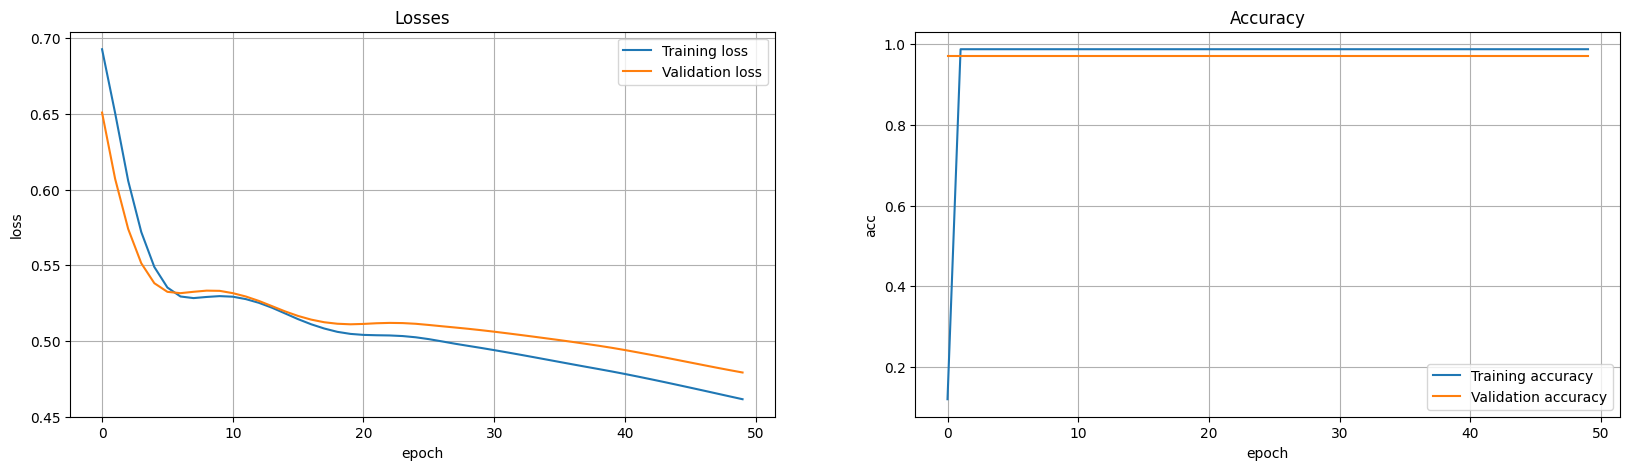

In [52]:
model_dense = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,  
    embedding_layer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])

model_dense.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["accuracy"])
model_dense.summary()
history_dense = model_dense.fit(data_train.tolist(), labels_train.tolist(), 
                    validation_data=(data_val.tolist(),labels_val.tolist()),
                    epochs=50,
                    batch_size=540)
graph_training_results(history_dense)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 32)               0         
 ectorization)                                                   
                                                                 
 Embedding (Embedding)       (None, 32, 300)           4915800   
                                                                 
 conv1d_14 (Conv1D)          (None, 30, 32)            28832     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 15, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 13, 32)            3104      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 7, 32)          

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


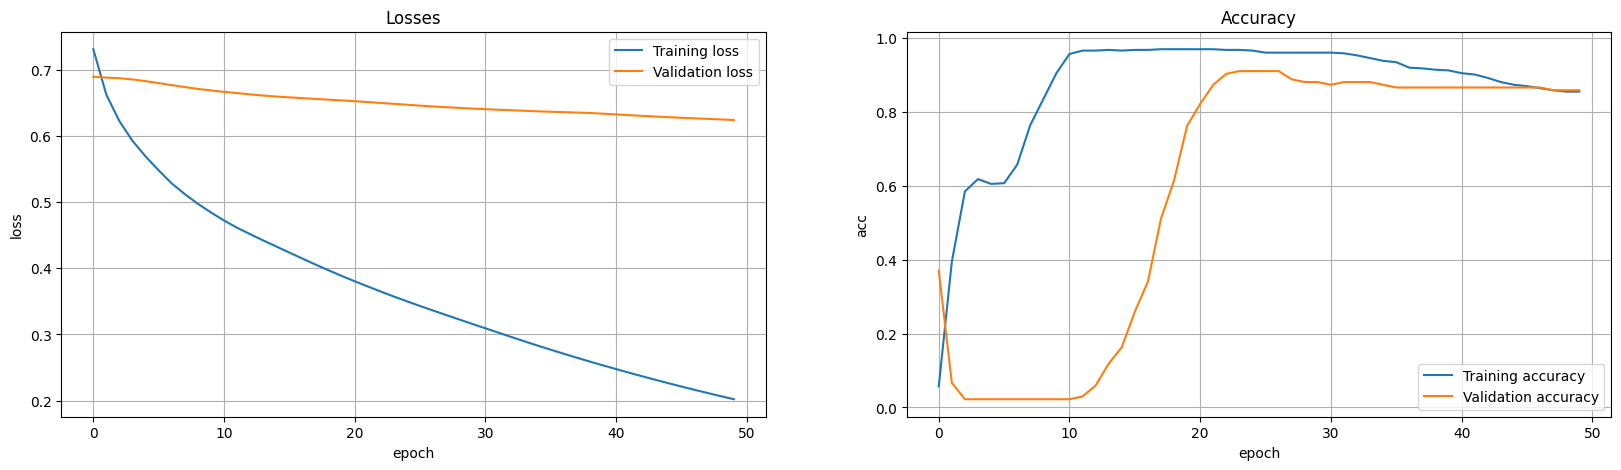

In [53]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,  
    embedding_layer,
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='sigmoid')
])

model_cnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["accuracy"])
model_cnn.summary()
history_cnn = model_cnn.fit(data_train.tolist(), labels_train.tolist(), 
                    validation_data=(data_val.tolist(),labels_val.tolist()),
                    epochs=50,
                    batch_size=540)
graph_training_results(history_cnn)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 32)               0         
 ectorization)                                                   
                                                                 
 Embedding (Embedding)       (None, 32, 300)           4915800   
                                                                 
 conv1d_16 (Conv1D)          (None, 30, 32)            28832     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 15, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 13, 32)            3104      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 7, 32)          

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


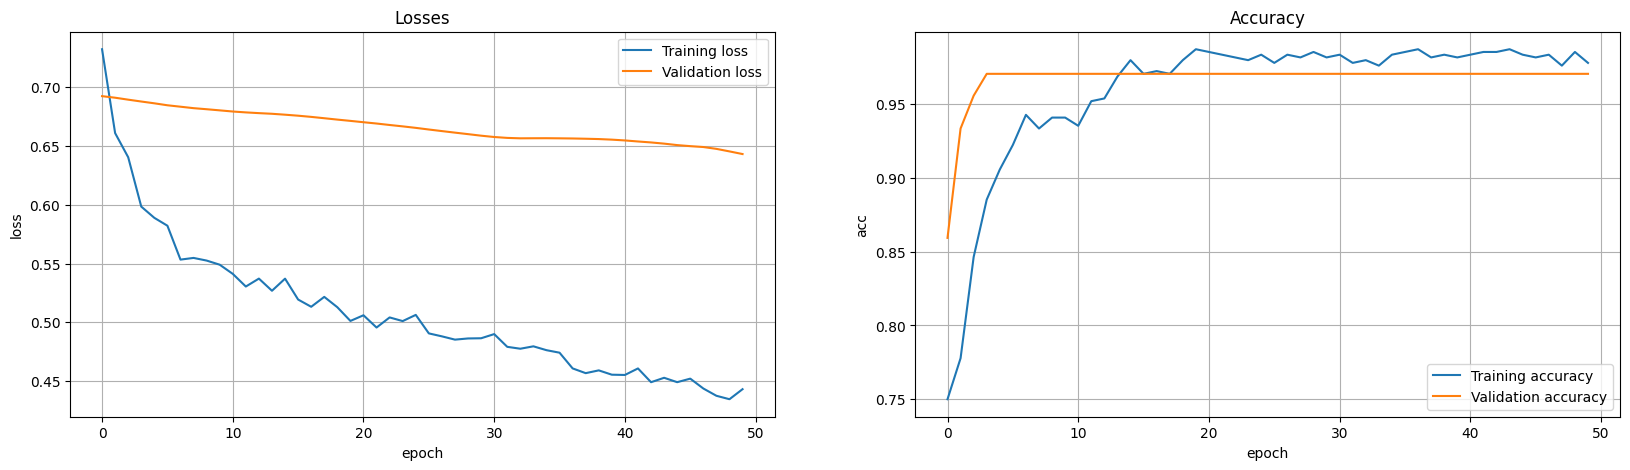

In [54]:
model_540 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,  
    embedding_layer,
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])

model_540.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["accuracy"])
model_540.summary()
history_540 = model_540.fit(data_train.tolist(), labels_train.tolist(), 
                    validation_data=(data_val.tolist(),labels_val.tolist()),
                    epochs=50,
                    batch_size=540)
graph_training_results(history_540)

In [55]:
data_test_list = data_test.tolist()
labels_test_list = labels_test.tolist()
pred = model_dense.predict(data_test_list)
predictions_list = []
for index,res in enumerate(pred):
    prediction = []
    for i in res:
        prediction.append(round(i))
    predictions_list.append(prediction)
    #print(data_test_list[index])
    #print(prediction)
acc = 0
for index,prediction in enumerate(predictions_list):
    print(data_test_list[index])
    print("correct result",labels_test_list[index])
    print("model prediction",prediction)
    if(prediction == labels_test_list[index]):
        acc +=1
print((acc/len(predictions_list))*100)

3/3 [==============================] - 0s 0s/step
Programme Analyst Pacific Digital Economy Programme
correct result [1, 1, 0, 0]
model prediction [1, 1, 1, 1]
Interpreter/Associate Translation Officer (English-Tigrinya-Amharic) at UNHCR Rwanda
correct result [1, 1, 1, 1]
model prediction [1, 1, 1, 1]
Communication and Reporting Assistant for UNDP in Afghanistan
correct result [1, 0, 1, 1]
model prediction [1, 1, 1, 1]
External Communications Officer
correct result [1, 1, 0, 0]
model prediction [1, 1, 0, 0]
HIV Specialist - Vientiane, Lao PDR
correct result [1, 1, 1, 0]
model prediction [1, 1, 0, 0]
Supply and Logistics Assistant (UNICEF)
correct result [1, 1, 0, 1]
model prediction [1, 1, 0, 0]
OCHA Information Management Associate
correct result [1, 1, 0, 1]
model prediction [1, 1, 0, 0]
Communications and Visibility Officer in Harare, Zimbabwe
correct result [1, 1, 1, 0]
model prediction [1, 1, 1, 1]
Programme Coordination Assistant (UNEP)
correct result [1, 0, 0, 1]
model predictio

In [56]:
data_test_list = data_test.tolist()
labels_test_list = labels_test.tolist()
pred = model_cnn.predict(data_test_list)
predictions_list = []
for index,res in enumerate(pred):
    prediction = []
    for i in res:
        prediction.append(round(i))
    predictions_list.append(prediction)
    #print(data_test_list[index])
    #print(prediction)
acc = 0
for index,prediction in enumerate(predictions_list):
    print(data_test_list[index])
    print("correct result",labels_test_list[index])
    print("model prediction",prediction)
    if(prediction == labels_test_list[index]):
        acc +=1
print((acc/len(predictions_list))*100)

3/3 [==============================] - 0s 0s/step
Programme Analyst Pacific Digital Economy Programme
correct result [1, 1, 0, 0]
model prediction [1, 1, 0, 0]
Interpreter/Associate Translation Officer (English-Tigrinya-Amharic) at UNHCR Rwanda
correct result [1, 1, 1, 1]
model prediction [1, 1, 0, 1]
Communication and Reporting Assistant for UNDP in Afghanistan
correct result [1, 0, 1, 1]
model prediction [1, 1, 1, 1]
External Communications Officer
correct result [1, 1, 0, 0]
model prediction [1, 1, 0, 0]
HIV Specialist - Vientiane, Lao PDR
correct result [1, 1, 1, 0]
model prediction [1, 1, 0, 1]
Supply and Logistics Assistant (UNICEF)
correct result [1, 1, 0, 1]
model prediction [1, 1, 0, 1]
OCHA Information Management Associate
correct result [1, 1, 0, 1]
model prediction [1, 1, 0, 1]
Communications and Visibility Officer in Harare, Zimbabwe
correct result [1, 1, 1, 0]
model prediction [1, 1, 0, 0]
Programme Coordination Assistant (UNEP)
correct result [1, 0, 0, 1]
model predictio

In [57]:
data_test_list = data_test.tolist()
labels_test_list = labels_test.tolist()
pred = model_540.predict(data_test_list)
predictions_list = []
for index,res in enumerate(pred):
    prediction = []
    for i in res:
        prediction.append(round(i))
    predictions_list.append(prediction)
    #print(data_test_list[index])
    #print(prediction)
acc = 0
for index,prediction in enumerate(predictions_list):
    print(data_test_list[index])
    print("correct result",labels_test_list[index])
    print("model prediction",prediction)
    if(prediction == labels_test_list[index]):
        acc +=1
print((acc/len(predictions_list))*100)

3/3 [==============================] - 0s 8ms/step
Programme Analyst Pacific Digital Economy Programme
correct result [1, 1, 0, 0]
model prediction [1, 1, 0, 0]
Interpreter/Associate Translation Officer (English-Tigrinya-Amharic) at UNHCR Rwanda
correct result [1, 1, 1, 1]
model prediction [1, 1, 1, 1]
Communication and Reporting Assistant for UNDP in Afghanistan
correct result [1, 0, 1, 1]
model prediction [1, 1, 1, 1]
External Communications Officer
correct result [1, 1, 0, 0]
model prediction [1, 0, 0, 0]
HIV Specialist - Vientiane, Lao PDR
correct result [1, 1, 1, 0]
model prediction [1, 1, 0, 0]
Supply and Logistics Assistant (UNICEF)
correct result [1, 1, 0, 1]
model prediction [1, 1, 0, 0]
OCHA Information Management Associate
correct result [1, 1, 0, 1]
model prediction [1, 1, 0, 0]
Communications and Visibility Officer in Harare, Zimbabwe
correct result [1, 1, 1, 0]
model prediction [1, 1, 0, 0]
Programme Coordination Assistant (UNEP)
correct result [1, 0, 0, 1]
model predicti